In [18]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [19]:
from fredapi import Fred

fred = Fred(api_key= '2d60db8717ba3d033f961ac04cf4855e')
ten_year_treasury_rate = fred.get_series('GS10')

#Set the risk free rate

risk_free_rate = ten_year_treasury_rate.iloc[-1] / 100
print(risk_free_rate)

0.0438


In [20]:
df = yf.download("AMT", period="1y", progress=False, threads=False)
print(df.tail())


Price            Close        High         Low        Open   Volume
Ticker             AMT         AMT         AMT         AMT      AMT
Date                                                               
2025-06-26  217.520004  221.580002  215.820007  220.789993  2040100
2025-06-27  217.779999  219.880005  215.869995  216.300003  2086300
2025-06-30  221.020004  221.130005  215.259995  217.389999  2071800
2025-07-01  224.470001  225.259995  220.619995  220.899994  2567600
2025-07-02  222.830002  224.960007  222.542801  222.820007  1937858


In [21]:
import yfinance as yf

df = yf.download("AAPL", period="1y")  # Apple Inc.
print(df.tail())
df = yf.download("AMT", start="2023-01-01", end="2024-01-01")
print(df.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-06-26  201.000000  202.639999  199.460007  201.429993  50799100
2025-06-27  201.080002  203.220001  200.000000  201.889999  73188600
2025-06-30  205.169998  207.389999  199.259995  202.009995  91912800
2025-07-01  207.820007  210.190002  206.139999  206.669998  78788900
2025-07-02  212.440002  213.339996  208.139999  209.080002  67834447
Price            Close        High         Low        Open   Volume
Ticker             AMT         AMT         AMT         AMT      AMT
Date                                                               
2023-12-22  203.220581  205.033784  201.775685  203.003378  1106400
2023-12-26  204.212189  204.920472  202.512306  203.305580  1053100
2023-12-27  206.287231  206.658457  203.707683  203.707683  1860500
2023-12-28  206.706039  207.810201  205.

In [22]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']



In [23]:
return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

In [24]:
muh = return_df['Close'].mean()
sigma = return_df['Close'].std()
returns = return_df['Close'].pct_change().dropna()

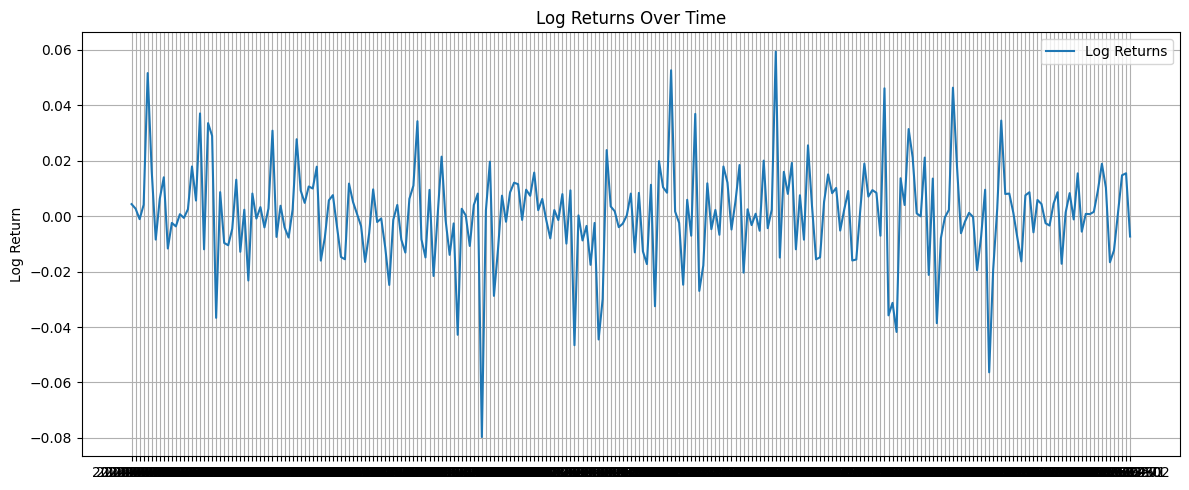

In [25]:
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])


plt.figure(figsize=(12, 5))
plt.plot(return_df['Date'], return_df['Log_Return'], label='Log Returns')

plt.ylabel('Log Return')
plt.title('Log Returns Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# Set parameters a b and c for frontier
#set rolling  mean and std

rolling_mean = return_df['Log_Return'].rolling(window=30).mean()
rolling_std = return_df['Log_Return'].rolling(window=30).std()
rolling_mean = rolling_mean.dropna()
rolling_std = rolling_std.dropna()
rolling_mean = rolling_mean.values
rolling_std = rolling_std.values
mu = rolling_mean
S = rolling_std
sigma = 0.04
N = 220
T = 240
nobs = 1000 


Sharpe Ratio: -2.5036660219170463


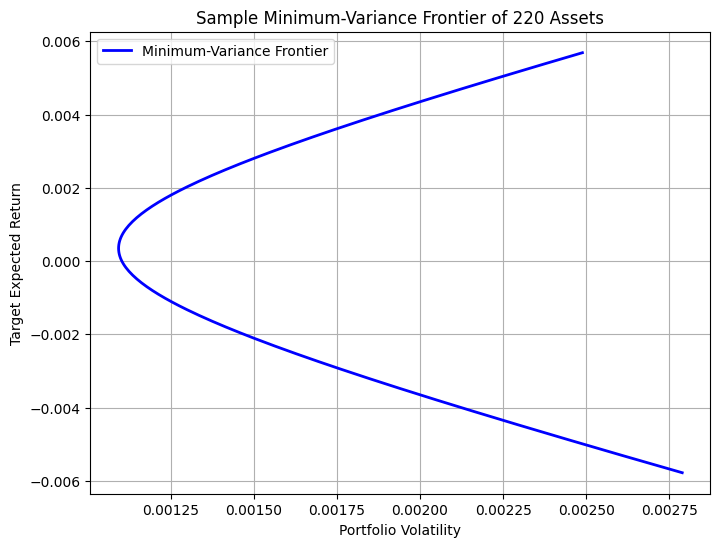

In [27]:
rolling_mean[:5] 
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate)
print(f"Sharpe Ratio: {sharpe_ratio}")
if S.ndim == 1:
    S = np.diag(S**2) 

inv_S = np.linalg.inv(S)
ones = np.ones(N) 

#calculate parameters a,b,c
a_hat = np.dot(mu, inv_S.dot(mu))       
b_hat = np.dot(ones, inv_S.dot(mu))      
c_hat = np.dot(ones, inv_S.dot(ones)) 

def compute_portfolio(mu_p):
    """
    Computing sigma based on given portfolio mean return
    """
    
    # Compute Lagrange multipliers directly inline:
    lambda1 = (a_hat - b_hat * mu_p) / (a_hat * c_hat - b_hat**2)
    lambda2 = (c_hat * mu_p - b_hat) / (a_hat * c_hat - b_hat**2)
    
    # Compute portfolio weights for target return mu_p:
    w = lambda1 * inv_S.dot(ones) + lambda2 * inv_S.dot(mu)
    
    # Compute portfolio volatility:
    sigma_p = np.sqrt(np.dot(w, S.dot(w)))
    return sigma_p

#predefining target return

if len(mu) != len(rolling_mean):
    raise ValueError(f"Length of mu ({len(mu)}) does not match the length of rolling_mean ({len(rolling_mean)}).")

target_returns = np.linspace(min(mu), max(mu), len(mu))

vols = []

for mu_p in target_returns:
    vols.append(compute_portfolio(mu_p))
volatilities = np.array(vols)

plt.figure(figsize=(8, 6))
plt.plot(volatilities, target_returns, 'b-', lw=2)
plt.xlabel("Portfolio Volatility")
plt.ylabel("Target Expected Return")
plt.title("Sample Minimum-Variance Frontier of 220 Assets")
plt.grid(True)
plt.legend(["Minimum-Variance Frontier"])
plt.show()

import json

frontier_data = {
    "volatility": volatilities.tolist(),
    "return": target_returns.tolist()
}

with open("frontier_data.json", "w") as f:
    json.dump(frontier_data, f)



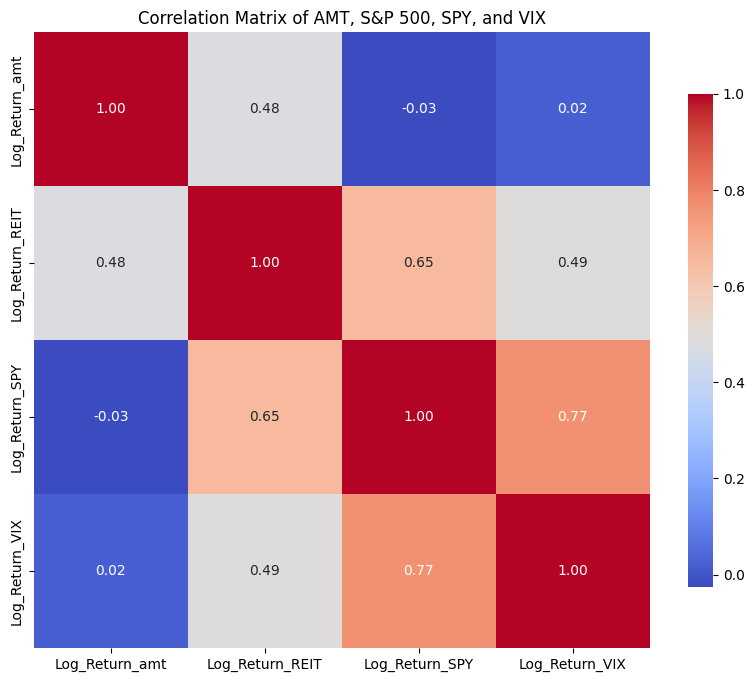

In [28]:
# create a correlation matrix for stocks AMT , AAPL, and S&P 500
altick = ['SPY']
return_df = yf.download(altick, period="1y", progress=False, threads=False)
return_df_alt= return_df[['Close']].reset_index()
return_df_alt.columns = ['Date', 'Close']
#set log returns for AAPL
return_df_alt['Date'] = pd.to_datetime(return_df_alt['Date'])
return_df_alt['Date'] = return_df_alt['Date'].dt.strftime('%Y-%m-%d')
return_df_alt['Log_Return_SPY'] = np.log(return_df_alt['Close'] / return_df_alt['Close'].shift(1))

altick = ['AMT']
return_df_amt = yf.download(altick, period="1y", progress=False, threads=False)
return_df_amt = return_df_amt[['Close']].reset_index()
return_df_amt.columns = ['Date', 'Close']
# Set log returns for AMT
return_df_amt['Date'] = pd.to_datetime(return_df_amt['Date'])
return_df_amt['Date'] = return_df_amt['Date'].dt.strftime('%Y-%m-%d')
return_df_amt['Log_Return_amt'] = np.log(return_df_amt['Close'] / return_df_amt['Close'].shift(1))

altick = ['REIT']  # S&P 500 index
return_df_sp500 = yf.download(altick, period="1y", progress=False, threads=False)
return_df_sp500 = return_df_sp500[['Close']].reset_index()
return_df_sp500.columns = ['Date', 'Close']
# Set log returns for S&P 500
return_df_sp500['Date'] = pd.to_datetime(return_df_sp500['Date'])
return_df_sp500['Date'] = return_df_sp500['Date'].dt.strftime('%Y-%m-%d')
return_df_sp500['Log_Return_REIT'] = np.log(return_df_sp500['Close'] / return_df_sp500['Close'].shift(1))

altick = ['AAPL']  # Volatility Index
return_df_vix = yf.download(altick, period="1y", progress=False, threads=False)
return_df_vix = return_df_vix[['Close']].reset_index()
return_df_vix.columns = ['Date', 'Close']
# Set log returns for VIX
return_df_vix['Date'] = pd.to_datetime(return_df_vix['Date'])
return_df_vix['Date'] = return_df_vix['Date'].dt.strftime('%Y-%m-%d')
return_df_vix['Log_Return_VIX'] = np.log(return_df_vix['Close'] / return_df_vix['Close'].shift(1))

# Create correlation matrix
correlation_matrix = pd.concat([
    return_df_amt['Log_Return_amt'], 
    return_df_sp500['Log_Return_REIT'], 
    return_df_alt['Log_Return_SPY'], 
    return_df_vix['Log_Return_VIX']
], axis=1).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of AMT, S&P 500, SPY, and VIX")
plt.show()


using capm for SML plot

Expected Return for AMT using CAPM: 0.038337316628765744
Slope (Beta) for AMT: 0.12826151169904457


/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_1176/1336325992.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return_df_sp500 = return_df_sp500[valid_indices]
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_1176/1336325992.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return_df_amt = return_df_amt[valid_indices]


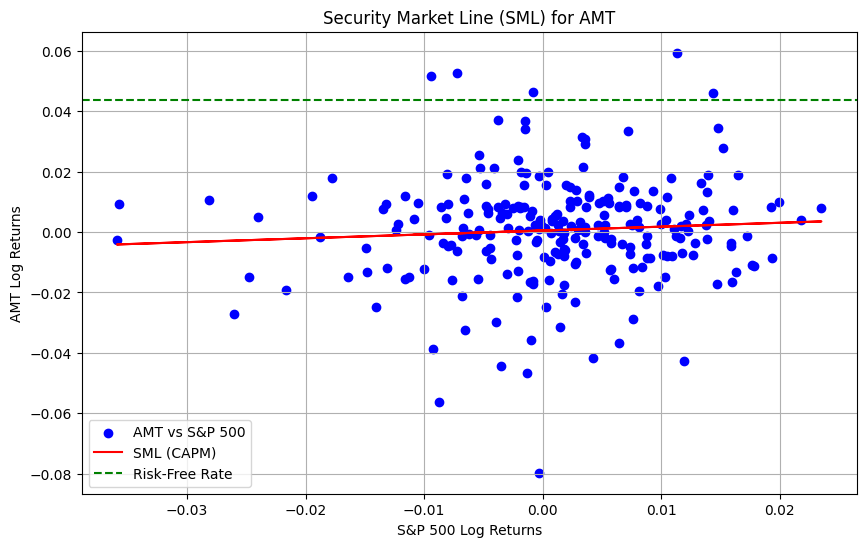

In [29]:
from sklearn.linear_model import LinearRegression

#plot the SML regression line for AMT vs S&P 500 using CAPM

#set ^GSPC as the market index
ticker = ['^GSPC']
return_df_sp500 = yf.download(ticker, period="5y", progress=False, threads=False)
return_df_sp500 = return_df_sp500[['Close']].reset_index()
return_df_sp500.columns = ['Date', 'Close']
return_df_sp500['Date'] = pd.to_datetime(return_df_sp500['Date'])
return_df_sp500['Date'] = return_df_sp500['Date'].dt.strftime('%Y-%m-%d')
return_df_sp500['Log_Return_sp'] = np.log(return_df_sp500['Close'] / return_df_sp500['Close'].shift(1))
return_df_sp500 = return_df_sp500.dropna(subset=['Log_Return_sp'])

valid_indices = return_df_sp500['Log_Return_sp'].notna() & return_df_amt['Log_Return_amt'].notna()
return_df_sp500 = return_df_sp500[valid_indices]
return_df_amt = return_df_amt[valid_indices]

X = return_df_sp500['Log_Return_sp'].values.reshape(-1, 1) #reshape value arrays dimenssions
y = return_df_amt['Log_Return_amt'].values.reshape(-1, 1)  # gives beta against the market return

model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0][0]
intercept = model.intercept_[0]
# Calculate the expected return using CAPM
expected_return = risk_free_rate + slope * (return_df_sp500['Log_Return_sp'].mean() - risk_free_rate)
print(f"Expected Return for AMT using CAPM: {expected_return}")
print(f"Slope (Beta) for AMT: {slope}")
# Plotting the Security Market Line (SML)
plt.figure(figsize=(10, 6))
plt.scatter(return_df_sp500['Log_Return_sp'], return_df_amt['Log_Return_amt'], label='AMT vs S&P 500', color='blue')
plt.plot(return_df_sp500['Log_Return_sp'], model.predict(X), color='red', label='SML (CAPM)')
plt.axhline(y=risk_free_rate, color='green', linestyle='--', label='Risk-Free Rate')
plt.xlabel('S&P 500 Log Returns')
plt.ylabel('AMT Log Returns')
plt.title('Security Market Line (SML) for AMT')
plt.legend()
plt.grid()
plt.show()

# use 5 year return index



In [30]:
#calculate alpha vs S&P 500 using CAPM

risk_free = sp500_data[['Close']].reset_index()
alpha =  0.040122072580808237
beta = 0.09493517145039645
# calculate alpha vs s&p 500 

